# Compute features based on spectral emergence
This notebook presents the spectral emergence concept and how it is implemented in the `signal` package.

In [1]:
%matplotlib notebook
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf

from wavely.signal.features import features
from wavely.signal.preprocessing import preprocessing
from wavely.signal.processing import processing
from wavely.signal.processing.event_detection import event_detection
from wavely.signal.units import helpers, converters

In [2]:
sys.path.append("../data/audio_sources/")

## Setup signals

In [3]:
block_size = 9600
rate = 96e3
frequencies = [2000, 0, 5000, 0, 10000]

total_length = 45.
sine_length = 5.

total_size = int(total_length * rate)
sine_size = int(sine_length * rate)
offset = int(10. * rate)

fade_in_out = processing.make_fade_in_out(rate)
dc_offset = preprocessing.make_dc_offset(rate, cutoff=26.)

sines = [
    np.sin(
        2.0
        * np.pi
        * f
        * np.arange(0.0, sine_length, 1 / rate)
    )
    for f in frequencies
]
noise = 0.05 * np.random.randn(total_size)

signal = noise.copy()
for i, sine in enumerate(sines):
    signal[offset + i * sine_size: offset + (i + 1) * sine_size] += fade_in_out(sine)
signal = preprocessing.max_abs_scaler(np.expand_dims(signal, 0), rate).squeeze()
signal = dc_offset(signal)

t_v = np.arange(0, total_length, 1 / rate)
f_v = np.arange(0, rate, rate / block_size)[:block_size // 2 + 1]

<IPython.core.display.Javascript object>


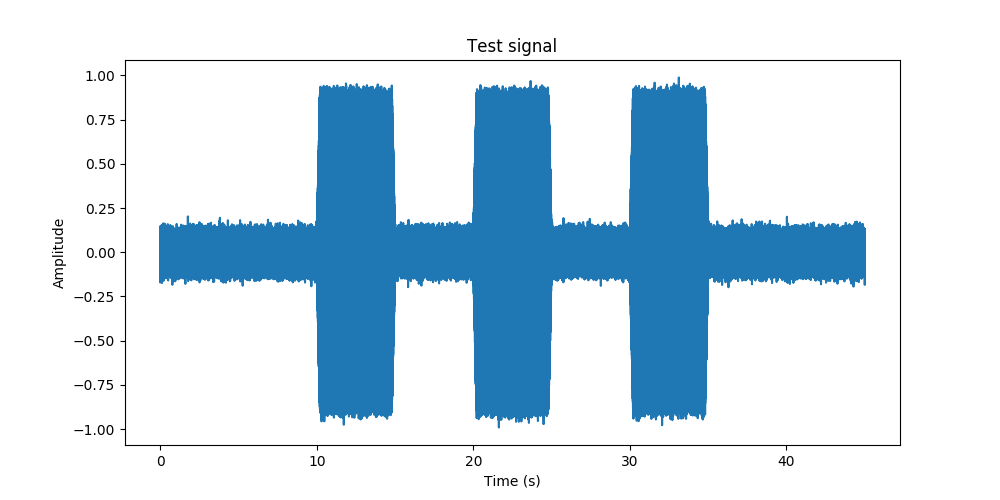

Text(0.5, 1.0, 'Test signal')

In [4]:
plt.figure(1, figsize=(10, 5))
plt.plot(t_v, signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Test signal")

## Setup features computers

In order to compute the spectral emergence, we have to compute a characteristic background noise. To do so, I compute the periodogram of the white noise and then use the `make_background_spectrum` function on the noise periodogram: it takes the mean over time of the periodogram to have a single spectrum, that characterizes the background noise. Since it is a mean, we have to consider a portion of the signal which contains only the noise.

In [5]:
noise_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)
signal_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
    features=["rms", "audiblelevel", "ultrasoundlevel"]
)
sine_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)
emergence_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)

## Setup an event detector
The detector will find the events of the signal.

In [6]:
def process_audio(
    signal_features: pd.DataFrame, 
    rate: float, 
    block_size: int,
    surrounding_time: float = 0
):
    detector = event_detection.TemporalEventDetector(
        frame_length=block_size/rate,
        surrounding_time=surrounding_time,
        integration_window=10.
    )
    events = []
    for index, feature in signal_features.iterrows():
        feature = dict(feature)
        feature["time"] = index
        detector.push(feature)
        events.append(detector.pop_event())
    events = [event for event in events if event is not None]
    return events

In [7]:
signal_features = signal_fc.compute(
    helpers.split_signal(signal, rate, block_size / rate)
)
n_frames = len(signal_features["rms"])
timestamps = pd.to_timedelta([i * block_size / rate for i in range(n_frames)], unit="s")
signal_features = pd.DataFrame(signal_features, index=timestamps)
events = process_audio(signal_features, rate, block_size)

In [8]:
events

[(Timedelta('0 days 00:00:09.800000'), Timedelta('0 days 00:00:14.800000')),
 (Timedelta('0 days 00:00:19.900000'), Timedelta('0 days 00:00:24.800000')),
 (Timedelta('0 days 00:00:29.900000'), Timedelta('0 days 00:00:34.800000'))]

In [9]:
end_noise_index = int((events[0][0] - timestamps[0]).total_seconds() * rate)

In [10]:
noise_feats = noise_fc.compute(
    helpers.split_signal(noise[:end_noise_index], rate, block_size / rate)
)

background_noise = preprocessing.make_background_spectrum(
    noise_fc["periodogram"]
)

<IPython.core.display.Javascript object>


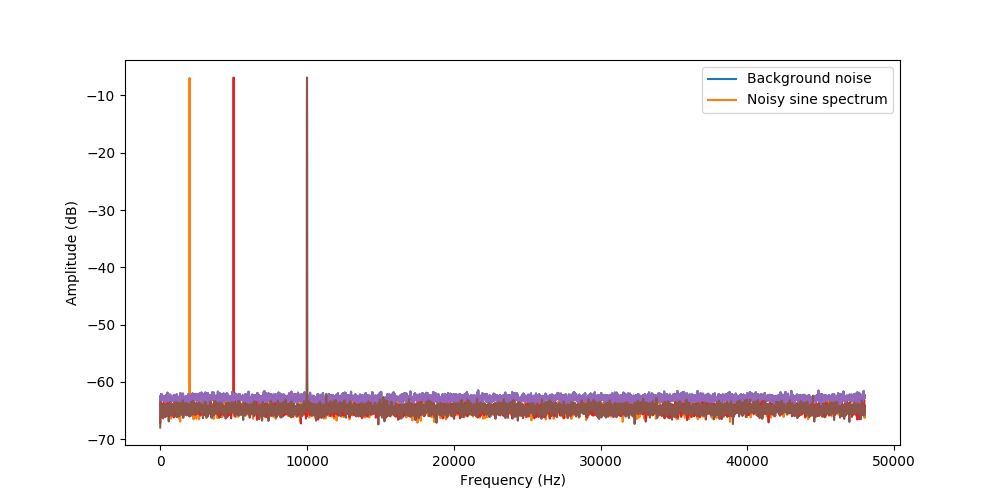

<IPython.core.display.Javascript object>


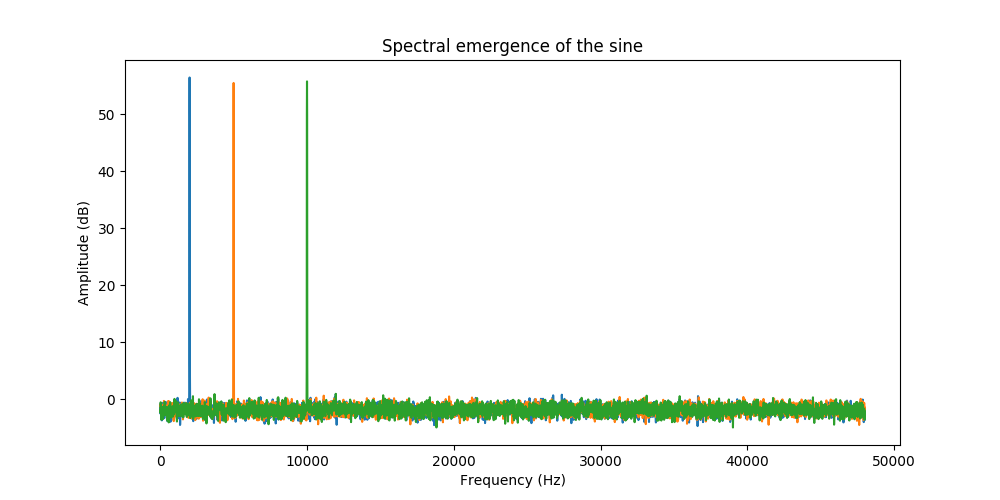

/home/maxime/.virtualenv/signal3.5/lib/python3.5/site-packages/wavely/signal/units/helpers.py:48: UserWarning: Since the step is not multiple of the length of the signal, `split_signal` will crop the final element of the new sliced signal.
  "Since the step is not multiple of the "


In [11]:
for event in events:
    start = int((event[0] - timestamps[0]).total_seconds() * rate)
    end = int((event[1] - timestamps[0]).total_seconds() * rate)
    signal_event = signal[start:end]
    emergence_feats = emergence_fc.compute(
        helpers.split_signal(
            signal_event, 
            rate, 
            block_size/rate,
        ), 
        background_spectrum=background_noise
    )
    sine_feats = sine_fc.compute(
        helpers.split_signal(
            signal_event, 
            rate, 
            block_size/rate,
        )
    )
    
    plt.figure(2, figsize=(10, 5))
    plt.plot(f_v, converters.lin2db(background_noise).T)
    plt.plot(f_v, converters.lin2db(sine_fc["periodogram"].mean(0)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.legend(["Background noise", "Noisy sine spectrum"])

    plt.figure(3, figsize=(10, 5))
    plt.plot(f_v, converters.lin2db(emergence_fc["periodogram"].mean(0)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.title("Spectral emergence of the sine")

## Compute spectral emergence of a signal from Bouygues using background noise
We use a signal recorded by a magneto using a `periodic` recording.

In [12]:
signal, rate = sf.read("../data/audio_sources/event_1.wav")

dc_offset = preprocessing.make_dc_offset(rate)
signal = dc_offset(signal)

<IPython.core.display.Javascript object>


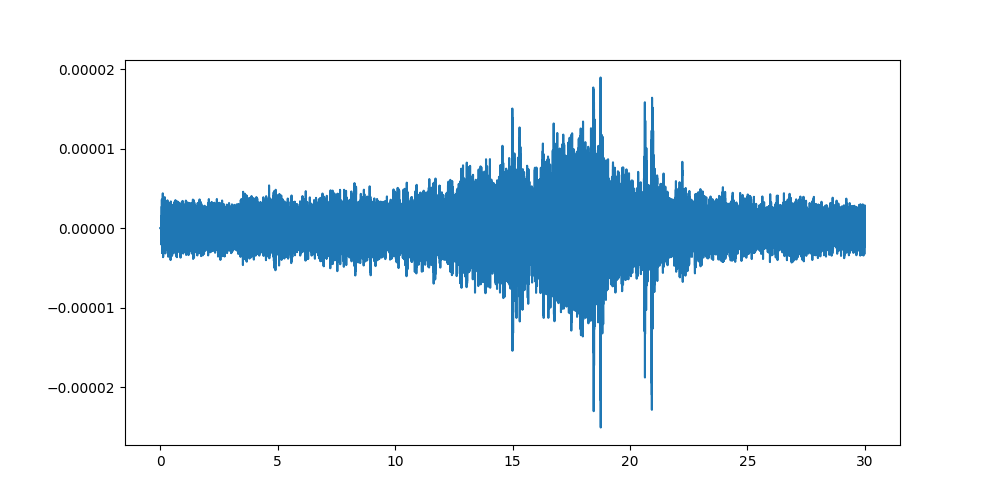

In [13]:
t_signal = np.arange(0, len(signal) / rate, 1 / rate)
plt.figure(4, figsize=(10, 5))
plt.plot(t_signal, signal)

In [14]:
noise_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)
signal_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
    features=["rms", "audiblelevel", "ultrasoundlevel"]
)
event_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)
emergence_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)

In [15]:
signal_features = signal_fc.compute(
    helpers.split_signal(signal, rate, block_size / rate)
)
n_frames = len(signal_features["rms"])
timestamps = pd.to_timedelta([i * block_size / rate for i in range(n_frames)], unit="s")
signal_features = pd.DataFrame(signal_features, index=timestamps)
events = process_audio(signal_features, rate, block_size, 1)

In [16]:
events

[(Timedelta('0 days 00:00:11.800000'), Timedelta('0 days 00:00:15.100000')),
 (Timedelta('0 days 00:00:14.700000'), Timedelta('0 days 00:00:19.800000'))]

The background spectrum is estimated using the mean signal spectrum up to the start of the event.

In [17]:
end_noise_index = int(
    (events[0][0] - timestamps[0]).total_seconds() * rate
) 

In [18]:
noise_feats = noise_fc.compute(
    helpers.split_signal(signal[:end_noise_index], rate, block_size / rate)
)

background_noise = preprocessing.make_background_spectrum(
    noise_fc["periodogram"], estimator="mean"
)

<IPython.core.display.Javascript object>


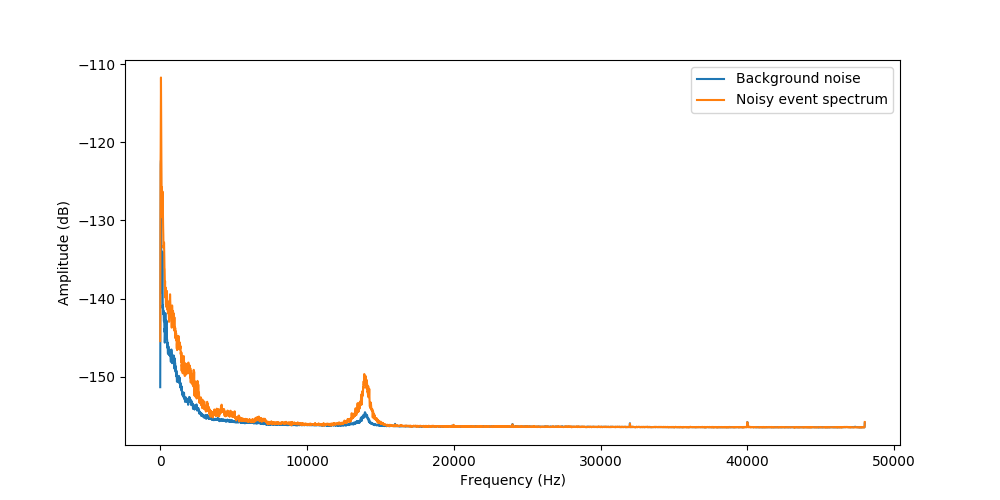

<IPython.core.display.Javascript object>


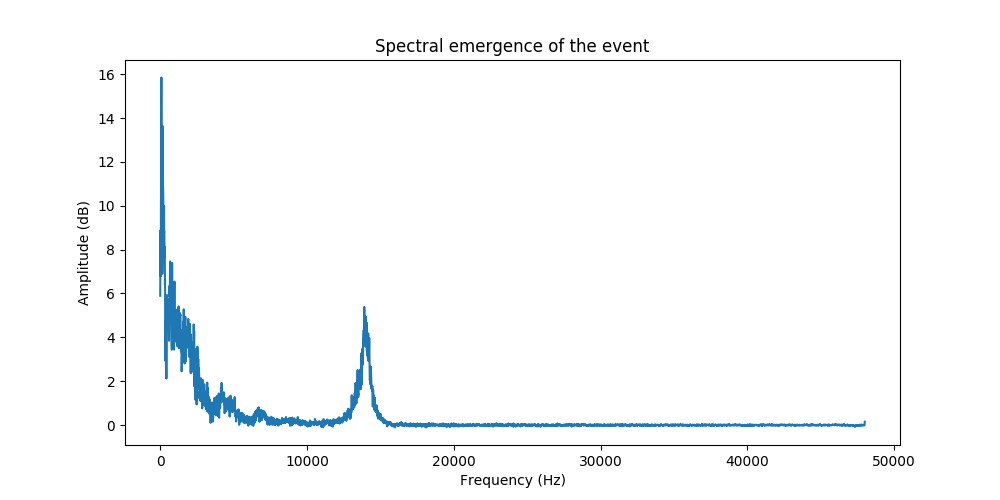

Text(0.5, 1.0, 'Spectral emergence of the event')

In [19]:
event = events[1]
start = int((event[0] - timestamps[0]).total_seconds() * rate)
end = int((event[1] - timestamps[0]).total_seconds() * rate)
signal_event = signal[start:end]

emergence_feats = emergence_fc.compute(
    helpers.split_signal(
        signal_event, 
        rate, 
        block_size/rate,
    ), 
    background_spectrum=background_noise
)
event_feats = event_fc.compute(
    helpers.split_signal(
        signal_event, 
        rate, 
        block_size/rate,
    )
)

plt.figure(5, figsize=(10, 5))
plt.plot(f_v, converters.lin2db(background_noise).T)
plt.plot(f_v, converters.lin2db(event_fc["periodogram"].mean(0)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Background noise", "Noisy event spectrum"])

plt.figure(6, figsize=(10, 5))
plt.plot(f_v, converters.lin2db(emergence_fc["periodogram"].mean(0)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.title("Spectral emergence of the event")

## Compute emergence on a real source without a portion of the signal containing only background noise
The considered source is a passing engine.

In [20]:
source, rate = sf.read("../data/audio_sources/engine.wav")
source = preprocessing.calibrate_audio_signal(source, microphone="VESPER_VM1000", rss_calibration=2.47)

dc_offset = preprocessing.make_dc_offset(rate)
source = dc_offset(source)
source = source[2*block_size:]

<IPython.core.display.Javascript object>


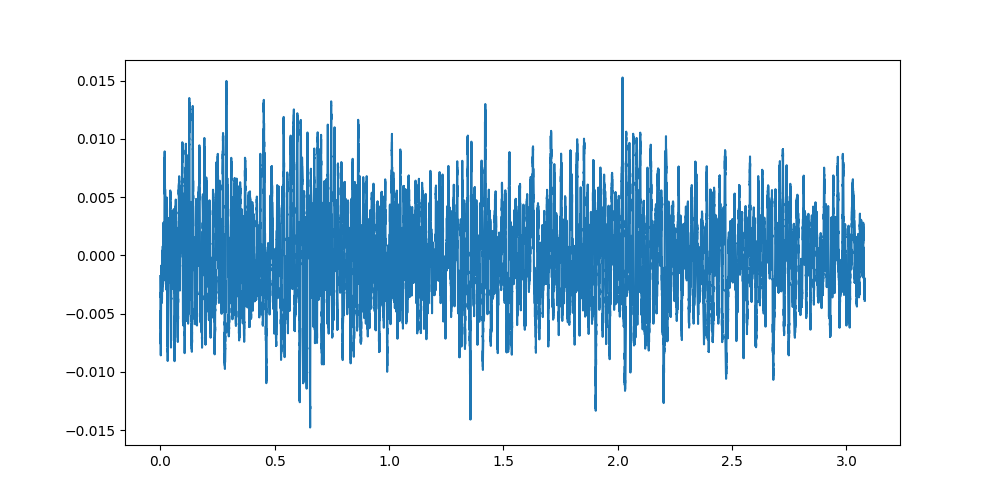

In [21]:
t_source = np.arange(0, len(source) / rate, 1 / rate)
plt.figure(7, figsize=(10, 5))
plt.plot(t_source, source)

The background spectrum is estimated using the 10th percentile of the signal since we don't have access to the surroundings of the event.

In [22]:
noise_feats = noise_fc.compute(
    helpers.split_signal(source, rate, block_size / rate)
)

background_noise = preprocessing.make_background_spectrum(
    noise_fc["periodogram"], estimator="percentile"
)

<IPython.core.display.Javascript object>


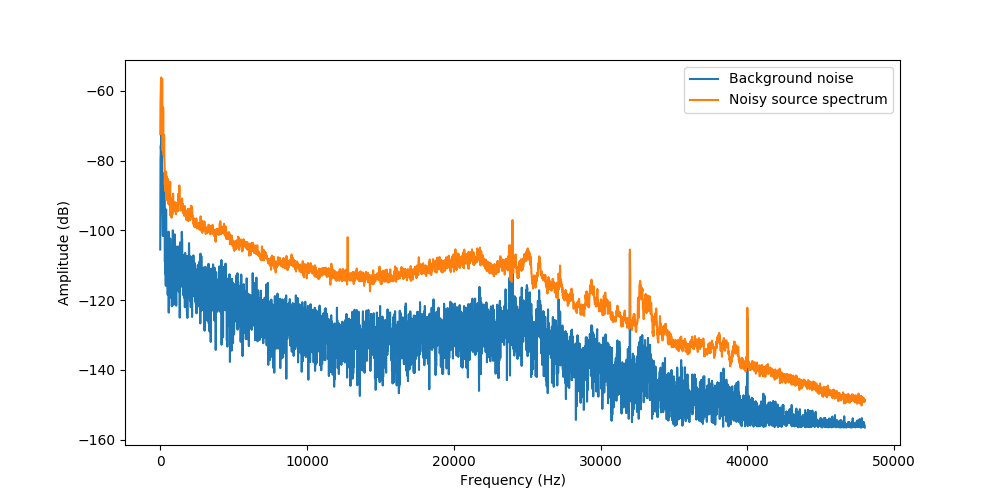

<IPython.core.display.Javascript object>


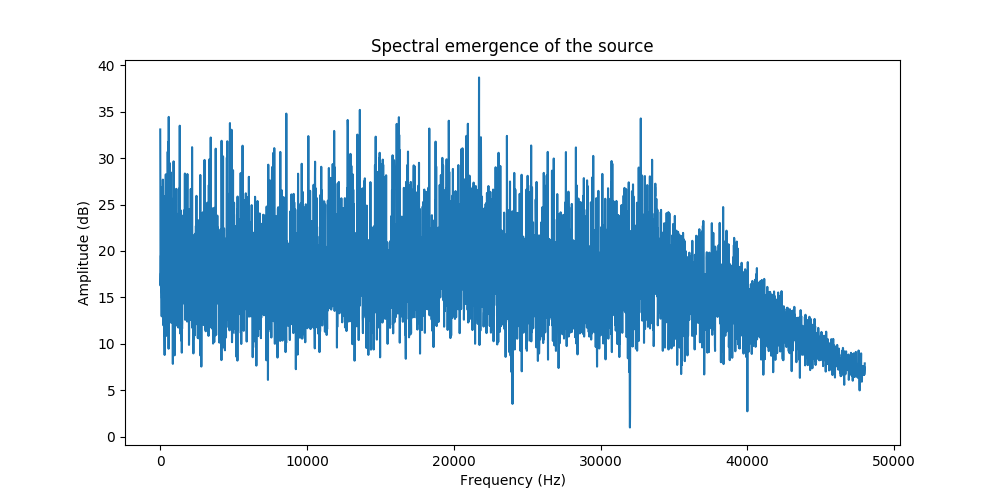

Text(0.5, 1.0, 'Spectral emergence of the source')

In [23]:
emergence_feats = emergence_fc.compute(
    helpers.split_signal(
        source, 
        rate, 
        block_size/rate,
    ), 
    background_spectrum=background_noise
)
sine_feats = sine_fc.compute(
    helpers.split_signal(
        source, 
        rate, 
        block_size/rate,
    )
)

plt.figure(8, figsize=(10, 5))
plt.plot(f_v, converters.lin2db(background_noise).T)
plt.plot(f_v, converters.lin2db(sine_fc["periodogram"].mean(0)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.legend(["Background noise", "Noisy source spectrum"])

plt.figure(9, figsize=(10, 5))
plt.plot(f_v, converters.lin2db(emergence_fc["periodogram"].mean(0)))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.title("Spectral emergence of the source")

## Online computation of the spectral emergence
The goal is to simulate a magneto recording signals, and compute emergence in real-time by updating the background spectrum when no event is detected.

In [24]:
surrounding_time = 1
detector = event_detection.TemporalEventDetector(
    frame_length=block_size/rate,
    surrounding_time=surrounding_time,
    integration_window=10.
)
signal_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
    features="all"
)
emergence_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
    features="all"
)
noise_fc = features.FeaturesComputer(
    block_size=block_size,
    rate=rate,
    n_fft=block_size,
    window=np.hanning,
)

blocks = helpers.split_signal(signal, rate, block_size / rate)
n_frames = blocks.shape[0]
timestamps = pd.to_timedelta([i * block_size / rate for i in range(n_frames)], unit="s")

background_noise_window_size = int(5 * rate / block_size)

update_background = False
events = []
last_event = (timestamps[0], timestamps[0])
noise_blocks = np.zeros((background_noise_window_size, block_size))
signal_laeq = np.zeros((n_frames, 9))
emergence_laeq = np.zeros((n_frames, 9))
for i, block in enumerate(blocks):
    # Update the background spectrum if enough data and not during an event
    if i > background_noise_window_size:
        noise_feats = noise_fc.compute(noise_blocks)
        background_spectrum = preprocessing.make_background_spectrum(
            noise_fc["periodogram"], estimator="percentile"
        )
    else:
        background_spectrum = None
    
    # Compute standard features and emergence ones
    block_features = signal_fc.compute(
        np.expand_dims(block, 0),
    )
    block_emergences = emergence_fc.compute(
        np.expand_dims(block, 0), 
        background_spectrum=background_spectrum
    )
    
    # Extract Bandleq from standard and emergence features
    signal_laeq[i, :] = block_features['bandleq']
    emergence_laeq[i, :] = block_emergences['bandleq']
    
    # Prepare features to push to detector
    block_features["time"] = timestamps[i]
    block_emergences["time"] = timestamps[i]
    detector.push(block_features)
    events.append(detector.pop_event())
    
    # Add a new block of noise
    noise_blocks = np.roll(noise_blocks, -1, axis=0)
    noise_blocks[-1, :] = block
events = [event for event in events if event is not None]


In [25]:
events

[(Timedelta('0 days 00:00:11.800000'), Timedelta('0 days 00:00:15.100000')),
 (Timedelta('0 days 00:00:14.700000'), Timedelta('0 days 00:00:19.800000'))]

<IPython.core.display.Javascript object>


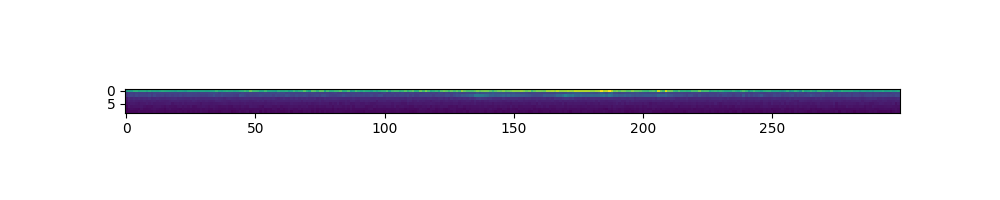

<IPython.core.display.Javascript object>


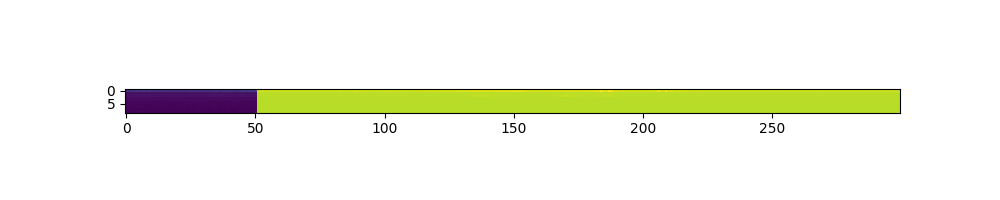

In [26]:
plt.figure(10, figsize=(10, 2))
plt.imshow(signal_laeq.T)
plt.figure(11, figsize=(10, 2))
plt.imshow(emergence_laeq.T)

In [27]:
emergence_laeq

array([[-28.41046075, -46.13641141, -46.44347604, ..., -52.87775161,
        -53.67046193, -53.77656562],
       [-26.17316029, -44.64600668, -45.05405427, ..., -50.88238547,
        -52.61913361, -52.99239176],
       [-26.87194347, -44.57138981, -44.27957718, ..., -51.49594425,
        -51.98405721, -52.85421531],
       ...,
       [126.95848194, 121.50587348, 121.4682891 , ..., 121.0777261 ,
        121.06543948, 121.04987852],
       [126.64581009, 121.48531912, 121.63210674, ..., 121.07158636,
        121.07107445, 121.05955175],
       [127.44064913, 121.50224806, 121.567246  , ..., 121.07440992,
        121.06189816, 121.05120713]])

In [28]:
signal_laeq

array([[-28.41046075, -46.13641141, -46.44347604, ..., -52.87775161,
        -53.67046193, -53.77656562],
       [-26.17316029, -44.64600668, -45.05405427, ..., -50.88238547,
        -52.61913361, -52.99239176],
       [-26.87194347, -44.57138981, -44.27957718, ..., -51.49594425,
        -51.98405721, -52.85421531],
       ...,
       [-26.79540494, -44.27793173, -44.58985389, ..., -51.43416882,
        -51.96744549, -52.7340636 ],
       [-26.14010826, -44.45444299, -43.29887769, ..., -51.68659928,
        -51.72153219, -52.24718135],
       [-24.78483828, -44.30843293, -43.77180305, ..., -51.56906085,
        -52.12663922, -52.66343539]])

In [29]:
block_emergences['melspectrogram']

array([[1.15812104e+03, 1.97692455e+03, 1.08319779e+02, 3.47994457e+01,
        2.05429266e+01, 7.23428407e+00, 3.22813925e+01, 4.12508649e+01,
        7.26369639e+01, 7.03862207e+00, 5.60157494e+00, 8.68113427e+00,
        6.36340487e+00, 1.19502292e+01, 8.89866415e+00, 1.99073228e+01,
        1.31246426e+01, 2.15145278e+00, 2.59790695e+00, 1.84996896e+00,
        2.82192693e+00, 2.56268679e-01, 1.23028459e+00, 4.19711751e-01,
        2.62687648e-01, 5.66983696e-01, 2.60768377e+00, 3.71095173e+00,
        3.32159038e+00, 1.07726636e+01, 4.94447559e+00, 2.55102482e+00,
        6.51446083e-01, 2.47742505e-01, 5.08670563e-01, 2.26589416e-01,
        4.31536895e-01, 3.72868112e-01, 4.63063196e-01, 1.08018756e-01,
        1.11545820e-01, 7.71168980e-02, 1.07566170e-01, 3.40648680e-02,
        1.36882034e-02, 1.64807492e-02, 2.01318054e-02, 1.98172130e-02,
        2.59477137e-02, 1.86666826e-02, 9.45147438e-03, 2.02805854e-02,
        1.10376076e-02, 1.17185496e-02, 1.63317966e-02, 1.071804

In [30]:
block_features['melspectrogram']

array([[3.38714339e-22, 2.59688397e-22, 1.60210428e-23, 1.96793568e-23,
        7.21545292e-24, 3.66076140e-24, 1.04325048e-23, 1.06745888e-23,
        1.79250751e-23, 5.00155294e-24, 3.53306329e-24, 4.50375350e-24,
        2.52424495e-24, 5.63478437e-24, 3.86705844e-24, 6.20587138e-24,
        5.54789880e-24, 1.85040294e-24, 2.24811738e-24, 1.46118852e-24,
        1.88201411e-24, 7.51358137e-25, 1.47046936e-24, 7.22684490e-25,
        5.74046842e-25, 1.06260001e-24, 2.04431856e-24, 2.43760532e-24,
        2.35842582e-24, 4.38341146e-24, 2.64358920e-24, 1.72131311e-24,
        1.08579793e-24, 6.87104624e-25, 9.37893082e-25, 4.91583639e-25,
        6.47123533e-25, 6.25076000e-25, 8.10636060e-25, 4.24138403e-25,
        4.16363218e-25, 3.20812503e-25, 3.65214682e-25, 1.79238009e-25,
        1.39580322e-25, 1.48778382e-25, 1.57072917e-25, 1.52597873e-25,
        1.70980314e-25, 1.46117653e-25, 8.53050950e-26, 1.61947803e-25,
        1.26728478e-25, 1.36554678e-25, 1.62160430e-25, 1.278642